### Get and Study Data

In [161]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Load the dataset
data_path = 'data/AAPL.csv'
df = pd.read_csv(data_path)

# Parse the 'Date' column and add it as a feature
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Date'] = df['Date'].map(lambda x: x.toordinal())  # Convert Date to numerical format

# Display basic information
df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,723161,0.128348,0.128348,469033600,0.128906,0.128348,0.099874
1,723164,0.121652,0.122210,175884800,0.122210,0.121652,0.094663
2,723165,0.112723,0.113281,105728000,0.113281,0.112723,0.087715
3,723166,0.115513,0.115513,86441600,0.116071,0.115513,0.089886
4,723167,0.118862,0.118862,73449600,0.119420,0.118862,0.092492


/tmp/ipykernel_6470/2930844890.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Close'], shade=True, color="blue")


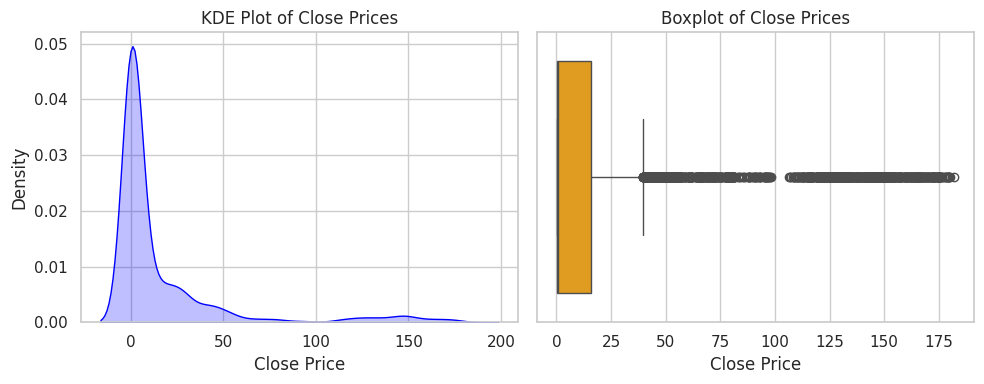

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots side by side
plt.figure(figsize=(10, 4))

# KDE plot for 'Close'
plt.subplot(1, 2, 1)
sns.kdeplot(df['Close'], shade=True, color="blue")
plt.title('KDE Plot of Close Prices')
plt.xlabel('Close Price')
plt.ylabel('Density')

# Boxplot for 'Close'
plt.subplot(1, 2, 2)
sns.boxplot(x=df['Close'], color="orange")
plt.title('Boxplot of Close Prices')
plt.xlabel('Close Price')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

#### Preprocessing

In [98]:
# Filter the dataset to remove rows where 'Close' > 50
df = df[df['Close'] <= 50]

# Reset the index after filtering to maintain consistency
df.reset_index(drop=True, inplace=True)

In [163]:
# Normalize all features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.drop(columns=['Close']))  # Scale input features

# Scale the target column 'Close'
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = target_scaler.fit_transform(df[['Close']])

# Define a function to create sequences for features and target
def create_sequences_multivariate(data, target, lookback):
    sequences = []
    targets = []
    for i in range(lookback, len(data)):
        sequences.append(data[i - lookback:i, :])  # Feature sequences
        targets.append(target[i, 0])  # Corresponding target value
    return np.array(sequences), np.array(targets)

# Set lookback window size
lookback = 30

# Create sequences for features and target
X, y = create_sequences_multivariate(scaled_data, scaled_close, lookback)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Print data shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (7392, 30, 6), y_train shape: (7392,)
X_val shape: (1584, 30, 6), y_val shape: (1584,)
X_test shape: (1584, 30, 6), y_test shape: (1584,)


#### Feature Importance

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# Train a RandomForestRegressor to estimate feature importances
# Flatten X_train and reshape it for RandomForest (ignoring sequential structure for simplicity in feature importance analysis)
n_features = X_train.shape[2]
X_train_flat = X_train.reshape(-1, n_features)
y_train_flat = np.repeat(y_train, X_train.shape[1])  # Repeat targets to match the flattened structure

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_flat, y_train_flat)

# Extract feature importances
feature_importances = rf.feature_importances_

/tmp/ipykernel_6470/3444856180.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance, y=feature_names, palette="viridis")


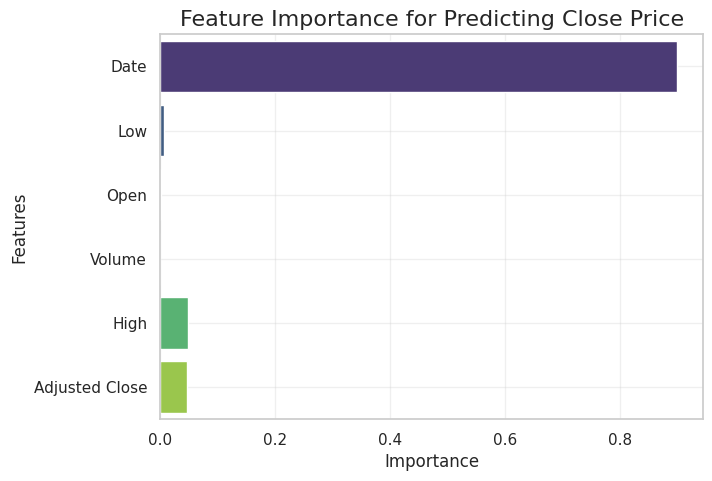

In [102]:
# Plot feature importance heatmap
def plot_feature_importance(importance, feature_names, title='Feature Importance Heatmap', figsize=(7,5)):
    """
    Plots a heatmap of feature importances.

    Parameters:
    - importance: Array of feature importances
    - feature_names: List of feature names
    - title: Title of the plot
    - figsize: Figure size
    """
    plt.figure(figsize=figsize)
    sns.barplot(x=importance, y=feature_names, palette="viridis")
    plt.title(title, fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# Get the feature names (columns except 'Close')
feature_names = df.drop(columns=['Close']).columns.tolist()

# Plot the feature importance heatmap
plot_feature_importance(feature_importances, feature_names, title='Feature Importance for Predicting Close Price')

### 1. Simple `SimpleRNN`

In [164]:
# Model 1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input

# Define the SimpleRNN model
simple_rnn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(50, activation='tanh'),
    Dense(1)  # Output layer for predicting the 'Close' price
])

# Compile the model with SGD optimizer and MSE loss
simple_rnn_model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# Display model summary
simple_rnn_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_11 (SimpleRNN)       │ (None, 50)             │         2,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,901 (11.33 KB)

 Trainable params: 2,901 (11.33 KB)

 Non-trainable params: 0 (0.00 B)

In [165]:
from tensorflow.keras.callbacks import EarlyStopping

# Train the model
history = simple_rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    verbose=0
)

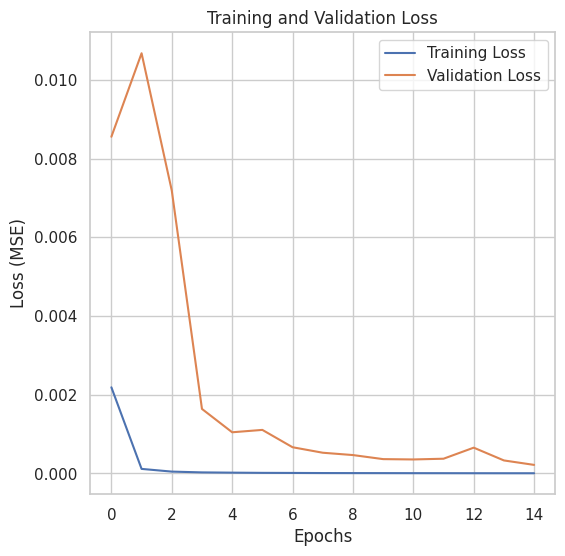

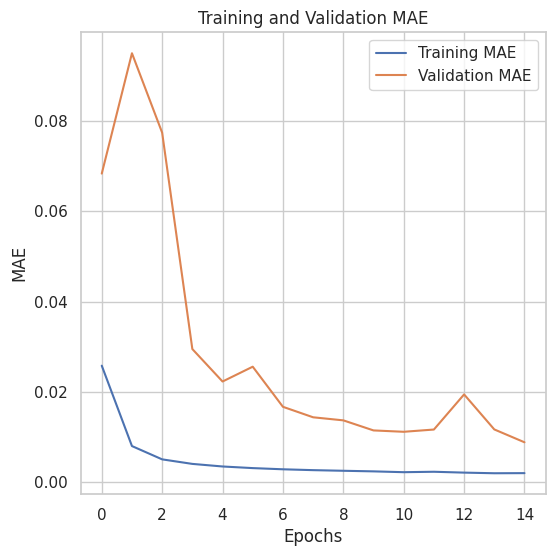

In [106]:
import matplotlib.pyplot as plt

# Plot the loss curves
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the MAE curves
plt.figure(figsize=(6, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and Validation MAE')
plt.show()

In [107]:
# Evaluate the model on the validation set
validation_loss, validation_mse = simple_rnn_model.evaluate(X_val, y_val, verbose=1)

# Calculate RMSE for validation set
validation_rmse = np.sqrt(validation_mse)

# Print validation evaluation results
print(f"Validation Loss (MSE): {validation_mse}")
print(f"Validation RMSE: {validation_rmse}")

# Return the evaluation metrics in case further processing or logging is needed
validation_results = {
    "Validation Loss (MSE)": validation_mse,
    "Validation RMSE": validation_rmse
}
pd.DataFrame([validation_results])

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 6.1865e-05 - mae: 0.0047
Validation Loss (MSE): 0.008846505545079708
Validation RMSE: 0.09405586395903079


,Validation Loss (MSE),Validation RMSE
0,0.008847,0.094056


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


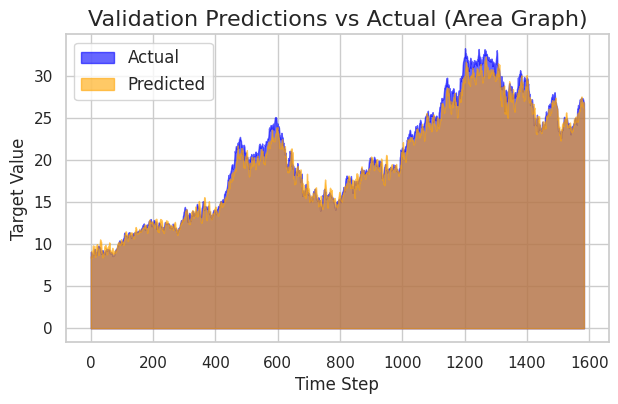

In [166]:
# Predict on the validation set
validation_predictions = simple_rnn_model.predict(X_val)

# Rescale the predictions and actual values to their original scale
y_val_unscaled = target_scaler.inverse_transform(y_val.reshape(-1, 1))
validation_predictions_unscaled = target_scaler.inverse_transform(validation_predictions)

# Plot area graph for predicted vs actual validation target
def plot_area_graph(actual, predicted, title='Validation Predictions vs Actual', figsize=(7,4)):
    """
    Plots an area graph to compare predicted and actual values.
    
    Parameters:
    - actual: Actual target values (unscaled)
    - predicted: Predicted target values (unscaled)
    - title: Title of the plot
    - figsize: Figure size
    """
    plt.figure(figsize=figsize)
    sns.set(style="whitegrid")
    plt.fill_between(range(len(actual)), actual.flatten(), alpha=0.6, label='Actual', color='blue')
    plt.fill_between(range(len(predicted)), predicted.flatten(), alpha=0.6, label='Predicted', color='orange')
    plt.title(title, fontsize=16)
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Target Value', fontsize=12)
    plt.legend(fontsize=12)
    plt.show()

# Call the function to plot the area graph
plot_area_graph(y_val_unscaled, validation_predictions_unscaled, title='Validation Predictions vs Actual (Area Graph)')

### 2. Sophisticated `SimpleRNN`

In [109]:
# Model 2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Define the Sophisticated SimpleRNN model
sophisticated_rnn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(64, activation='tanh', kernel_regularizer=l2(0.01), return_sequences=True),
    Dropout(0.2),
    SimpleRNN(32, activation='tanh', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(1)  # Output layer for predicting the 'Close' price
])

# Compile the model with Adam optimizer and MSE loss
sophisticated_rnn_model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# Display model summary
sophisticated_rnn_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_9 (SimpleRNN)        │ (None, 30, 64)         │         4,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

In [110]:
# Train the model
history_sophisticated = sophisticated_rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    verbose=0
)

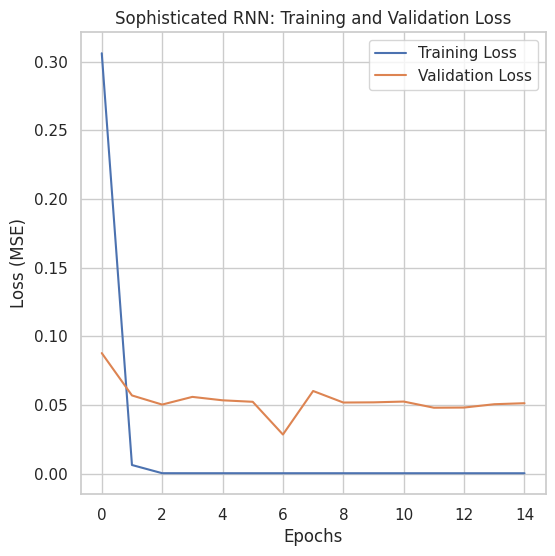

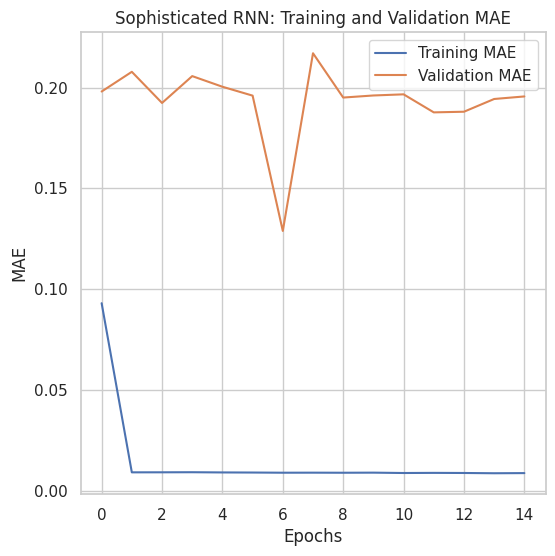

In [111]:
# Plot the loss curves
plt.figure(figsize=(6, 6))
plt.plot(history_sophisticated.history['loss'], label='Training Loss')
plt.plot(history_sophisticated.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Sophisticated RNN: Training and Validation Loss')
plt.show()

# Plot the MAE curves
plt.figure(figsize=(6, 6))
plt.plot(history_sophisticated.history['mae'], label='Training MAE')
plt.plot(history_sophisticated.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Sophisticated RNN: Training and Validation MAE')
plt.show()

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step


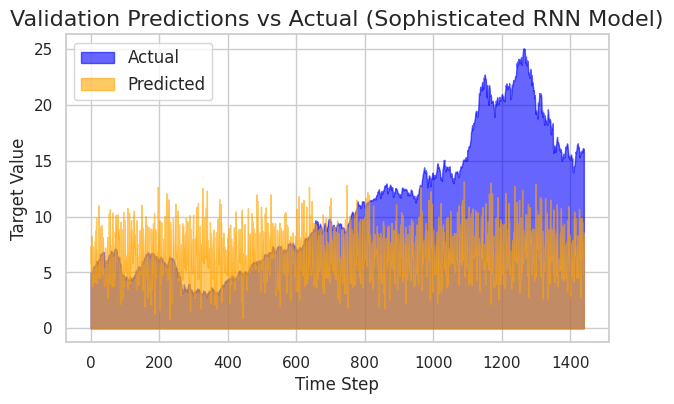

In [130]:
# Predict on the validation set using the sophisticated RNN model
validation_predictions_sophisticated = sophisticated_rnn_model.predict(X_val)

# Rescale the predictions and actual values to their original scale
validation_predictions_sophisticated_unscaled = target_scaler.inverse_transform(validation_predictions_sophisticated)

# Plot area graph for sophisticated RNN model predictions vs actual values
plot_area_graph(
    y_val_unscaled,
    validation_predictions_sophisticated_unscaled),
    title='Validation Predictions vs Actual (Sophisticated RNN Model)'
)

### 3. `GRU`

In [131]:
# Model 3
from tensorflow.keras.layers import GRU

# Define the GRU model
gru_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(16, activation='tanh', return_sequences=True),
    Dropout(0.2),
    Dense(1)  # Output layer for predicting the 'Close' price
])

# Compile the model with Adam optimizer and MSE loss
gru_model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# Display model summary
gru_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 30, 16)         │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 30, 1)          │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

In [132]:
# Train the GRU model
history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=0
)

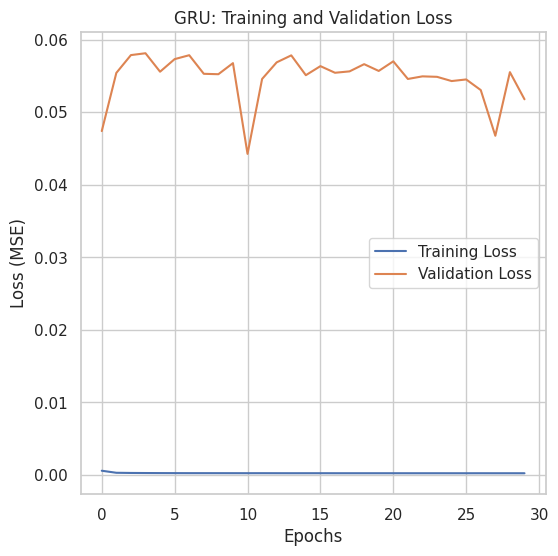

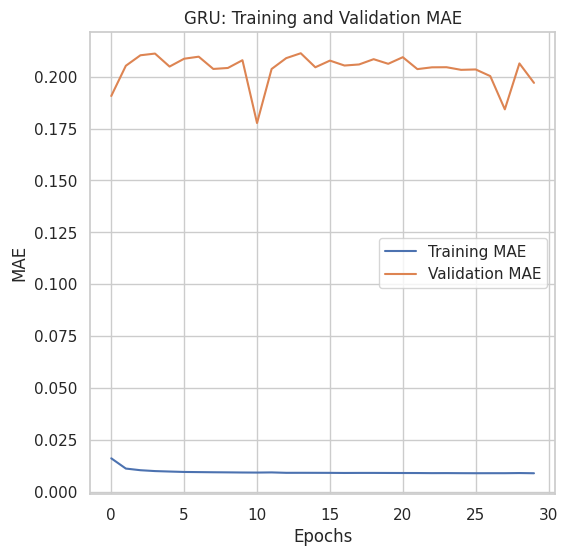

In [133]:
    # Plot the loss curves
plt.figure(figsize=(6, 6))
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('GRU: Training and Validation Loss')
plt.show()

# Plot the MAE curves
plt.figure(figsize=(6, 6))
plt.plot(history_gru.history['mae'], label='Training MAE')
plt.plot(history_gru.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('GRU: Training and Validation MAE')
plt.show()

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


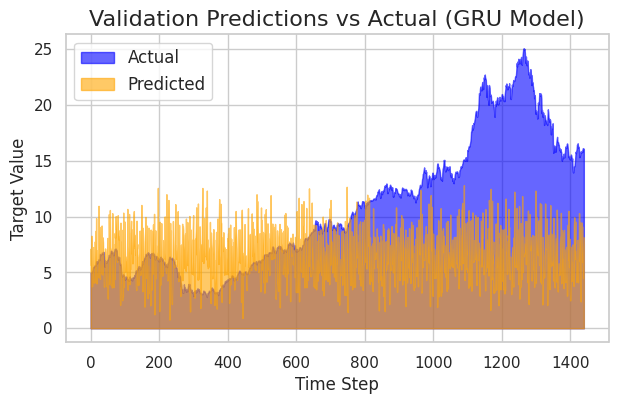

In [137]:
# Predict on the validation set using the GRU model
validation_predictions_gru = gru_model.predict(X_val)

# Reshape predictions to 2D for scaling
validation_predictions_gru_2d = validation_predictions_gru.reshape(-1, 1)[:1541]

# Rescale the predictions and actual values to their original scale
validation_predictions_gru_unscaled = target_scaler.inverse_transform(validation_predictions_gru_2d).reshape(-1)

# Reshape y_val for scaling back
y_val_2d = y_val.reshape(-1, 1)
y_val_unscaled = target_scaler.inverse_transform(y_val_2d).reshape(-1)

# Plot area graph for GRU model predictions vs actual values
plot_area_graph(
    y_val_unscaled,
    validation_predictions_gru_unscaled,
    title='Validation Predictions vs Actual (GRU Model)'
)


### Simple `SimpleRNN` with `Adam`

In [167]:
# Compile the model with SGD optimizer and MSE loss
simple_rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display model summary
simple_rnn_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_11 (SimpleRNN)       │ (None, 50)             │         2,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,901 (11.33 KB)

 Trainable params: 2,901 (11.33 KB)

 Non-trainable params: 0 (0.00 B)

In [168]:
# Train the model
history = simple_rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    verbose=0
)

In [160]:
simple_rnn_model.evaluate(X_test, y_test)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 1.9877e-05 - mae: 0.0030


[5.6050397688522935e-05, 0.004759816452860832]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
Final Evaluation Metrics for Simple RNN Model on Test Set:
Test MAE: 0.0026
Test RMSE: 0.0034


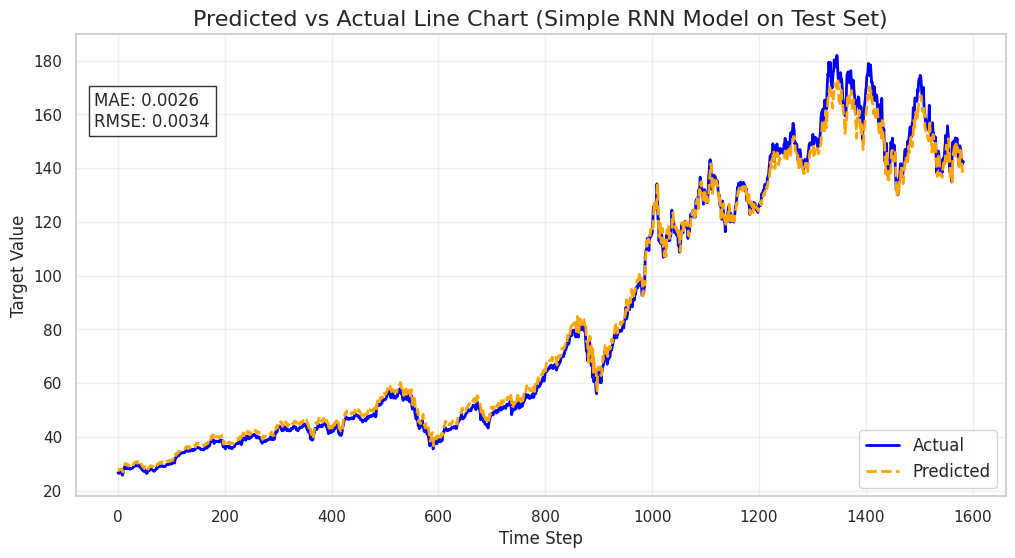


MAE:  0.0026255458472955106 
RMSE:  0.003387481507219758


In [174]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate the simple RNN model on the test set
test_predictions_simple = simple_rnn_model.predict(X_test)

# Rescale the predictions and actual test values to their original scale
test_predictions_simple_unscaled = target_scaler.inverse_transform(test_predictions_simple)
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
test_mae = mean_absolute_error(y_test_unscaled, test_predictions_simple_unscaled)
test_rmse = np.sqrt(mean_squared_error(y_test_unscaled, test_predictions_simple_unscaled))

# Display final evaluation metrics
print("Final Evaluation Metrics for Simple RNN Model on Test Set:")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Plot predicted vs actual line graph
def plot_test_line_chart_with_metrics(actual, predicted, title='Predicted vs Actual (Test Set)', figsize=(12, 6)):
    """
    Plots a line chart to compare predicted and actual test set values and annotates MAE and RMSE.
    
    Parameters:
    - actual: Actual test target values (unscaled)
    - predicted: Predicted test target values (unscaled)
    - title: Title of the plot
    - figsize: Figure size
    """
    plt.figure(figsize=figsize)
    sns.lineplot(x=range(len(actual)), y=actual.flatten(), label='Actual', color='blue', linewidth=2)
    sns.lineplot(x=range(len(predicted)), y=predicted.flatten(), label='Predicted', color='orange', linewidth=2, linestyle="--")
    plt.title(title, fontsize=16)
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Target Value', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)

    # Annotate MAE and RMSE on the plot
    metrics_text = f"MAE: {test_mae:.4f}\nRMSE: {test_rmse:.4f}"
    plt.gca().text(0.02, 0.8, metrics_text, transform=plt.gca().transAxes,
                   fontsize=12, bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.show()
    return test_mae, test_rmse

# Plot the line chart for test set predictions vs actual values with metrics
test_mae, test_rmse = plot_test_line_chart_with_metrics(
    y_test_unscaled,
    test_predictions_simple_unscaled,
    title='Predicted vs Actual Line Chart (Simple RNN Model on Test Set)'
)

print('\nMAE: ', test_mae, '\nRMSE: ', test_rmse)